# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
	set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [4]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(1, 2, 2, dtype=int).tolist(), # 100, for CI tests
		# np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k, notebook results from this set
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [5]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [6]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    set_serialize_minimal_threshold(None)
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize_full', _d_cpy._serialize_full, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    # info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
    #     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    # )
    # row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load_legacy', lambda: MazeDataset._load_legacy(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_full', lambda: MazeDataset._load_full(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'


    # default
    set_serialize_minimal_threshold(None)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    # read_legacy
    set_serialize_minimal_threshold(-1)
    row_data.update(wrapped_timeit_fancy(
        'read_legacy', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    
    
    #default read
    set_serialize_minimal_threshold(None)
    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    set_serialize_minimal_threshold(0)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    set_serialize_minimal_threshold(None)

    return row_data

## Run Profiling

In [7]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/9:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000120533A0790>, maze_ctor_kwargs={})
	{'grid_n': 10, 'n_mazes': 1, 'serialize_full': 0.010118399979546666, 'serialize_minimal': 0.016126599977724254, 'serialize_minimal_soln_cat': 0.012232600012794137, 'load_legacy': 0.027733700000680983, 'load_full': 0.02125639992300421, 'load_minimal': 0.006606400012969971, 'load_minimal_soln_cat': 0.015047699911519885, 'save': 0.13837689999490976, 'read_legacy': 0.08159169997088611, 'read': 0.019287699949927628, 'save_minimal': 0.14080260007176548, 'read_minimal': 0.024869300075806677}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_

### Results

In [8]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

# SPEEDS.loc[:,"load_legacy":"load_minimal_soln_cat:profiling"]
SPEEDS.loc[:,"read_legacy":"read:profiling"]


,read_legacy,read_legacy:stats,read_legacy:profiling,read,read:stats,read:profiling
0,0.081592,{0.08159169997088611: 1},<pstats.Stats object at 0x000001205377AAD0>,0.019288,{0.019287699949927628: 1},<pstats.Stats object at 0x0000012053779ED0>
1,0.067458,{0.06745790003333241: 1},<pstats.Stats object at 0x0000012053779510>,0.034918,{0.03491849999409169: 1},<pstats.Stats object at 0x00000120537780A0>
2,0.157477,{0.15747710003051907: 1},<pstats.Stats object at 0x0000012053778C10>,0.132776,{0.13277580006979406: 1},<pstats.Stats object at 0x0000012053779030>
3,0.397537,{0.39753690001089126: 1},<pstats.Stats object at 0x0000012053778DF0>,0.414211,{0.41421060007996857: 1},<pstats.Stats object at 0x0000012053778B80>
4,0.110599,{0.11059940000995994: 1},<pstats.Stats object at 0x00000120537784F0>,0.080178,{0.08017820003442466: 1},<pstats.Stats object at 0x000001204B9A4490>
5,4.037361,{4.037360899965279: 1},<pstats.Stats object at 0x00000120551FB460>,3.287609,{3.2876091999933124: 1},<pstats.Stats object at 0x00000120551FA560>
6,11.532839,{11.53283859998919: 1},<pstats.Stats object at 0x0000012053E99F00>,11.102842,{11.102842099964619: 1},<pstats.Stats object at 0x00000120616CF5E0>
7,2.088342,{2.0883417000295594: 1},<pstats.Stats object at 0x00000120551FB250>,2.176210,{2.1762104000663385: 1},<pstats.Stats object at 0x0000012053779BA0>
8,6.638626,{6.638626400032081: 1},<pstats.Stats object at 0x00000120567B3A60>,6.645728,{6.645728499977849: 1},<pstats.Stats object at 0x00000120619F0D90>


In [9]:
SPEEDS.columns

Index(['grid_n', 'n_mazes', 'serialize_full', 'serialize_full:stats',
       'serialize_full:profiling', 'serialize_minimal',
       'serialize_minimal:stats', 'serialize_minimal:profiling',
       'serialize_minimal_soln_cat', 'serialize_minimal_soln_cat:stats',
       'serialize_minimal_soln_cat:profiling', 'load_legacy',
       'load_legacy:stats', 'load_legacy:profiling', 'load_full',
       'load_full:stats', 'load_full:profiling', 'load_minimal',
       'load_minimal:stats', 'load_minimal:profiling', 'load_minimal_soln_cat',
       'load_minimal_soln_cat:stats', 'load_minimal_soln_cat:profiling',
       'save', 'save:stats', 'save:profiling', 'read_legacy',
       'read_legacy:stats', 'read_legacy:profiling', 'read', 'read:stats',
       'read:profiling', 'save_minimal', 'save_minimal:stats',
       'save_minimal:profiling', 'read_minimal', 'read_minimal:stats',
       'read_minimal:profiling'],
      dtype='object')

In [10]:


def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
    # for prefix in column_measurement_prefixes:
    #     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
    speeds['serialize/speedup'] = speeds['serialize_full'] / speeds['serialize_minimal']
    speeds['load_minimal/speedup'] = speeds['load_legacy'] / speeds['load_minimal']
    speeds['load/speedup'] = speeds['load_legacy'] / speeds['load_full']
    speeds['save/speedup'] = speeds['save'] / speeds['save_minimal']
    speeds['read_minimal/speedup'] = speeds['read_legacy'] / speeds['read_minimal']
    speeds['read/speedup'] = speeds['read_legacy'] / speeds['read']

    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [11]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_legacy,load_full,load_minimal,load_minimal_soln_cat,save,read_legacy,read,save_minimal,read_minimal,serialize/speedup,load_minimal/speedup,load/speedup,save/speedup,read_minimal/speedup,read/speedup
0,10,1,0.010118,0.016127,0.012233,0.027734,0.021256,0.006606,0.015048,0.138377,0.081592,0.019288,0.140803,0.024869,0.627435,4.198005,1.304722,0.982772,3.280820,4.230245
1,10,3,0.013521,0.016555,0.017360,0.073977,0.061716,0.007989,0.033826,0.404282,0.067458,0.034918,0.129566,0.029058,0.816761,9.260143,1.198654,3.120279,2.321515,1.931867
2,10,10,0.012695,0.013521,0.011701,0.111629,0.112247,0.005758,0.015204,0.215535,0.157477,0.132776,0.127784,0.026702,0.938909,19.386679,0.994485,1.686711,5.897489,1.186038
3,10,31,0.017504,0.020895,0.024704,0.359566,0.320553,0.007951,0.016709,0.382729,0.397537,0.414211,0.104935,0.026584,0.837704,45.224383,1.121705,3.647285,14.953822,0.959746
4,10,100,0.011809,0.008590,0.008608,0.075256,0.044898,0.010116,0.020406,0.463713,0.110599,0.080178,0.135164,0.036618,1.374703,7.438970,1.676146,3.430738,3.020315,1.379420
5,10,316,0.020196,0.214191,0.182968,4.406342,4.827018,0.027169,0.039050,1.039240,4.037361,3.287609,0.138403,0.069432,0.094290,162.184506,0.912850,7.508795,58.148501,1.228054
6,10,1000,0.028555,0.405730,0.447233,10.831598,11.665322,0.060839,0.094049,3.186651,11.532839,11.102842,0.192057,0.095407,0.070378,178.036493,0.928530,16.592260,120.880804,1.038729
7,10,3162,0.068430,0.026080,0.058013,1.692738,1.395122,0.185913,0.209718,1.529055,2.088342,2.176210,0.360915,0.251595,2.623879,9.105019,1.213326,4.236613,8.300400,0.959623
8,10,10000,0.206999,0.066226,0.166176,4.567262,4.444768,0.588079,0.712003,4.953136,6.638626,6.645728,0.851196,0.628984,3.125647,7.766408,1.027559,5.819033,10.554525,0.998931


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


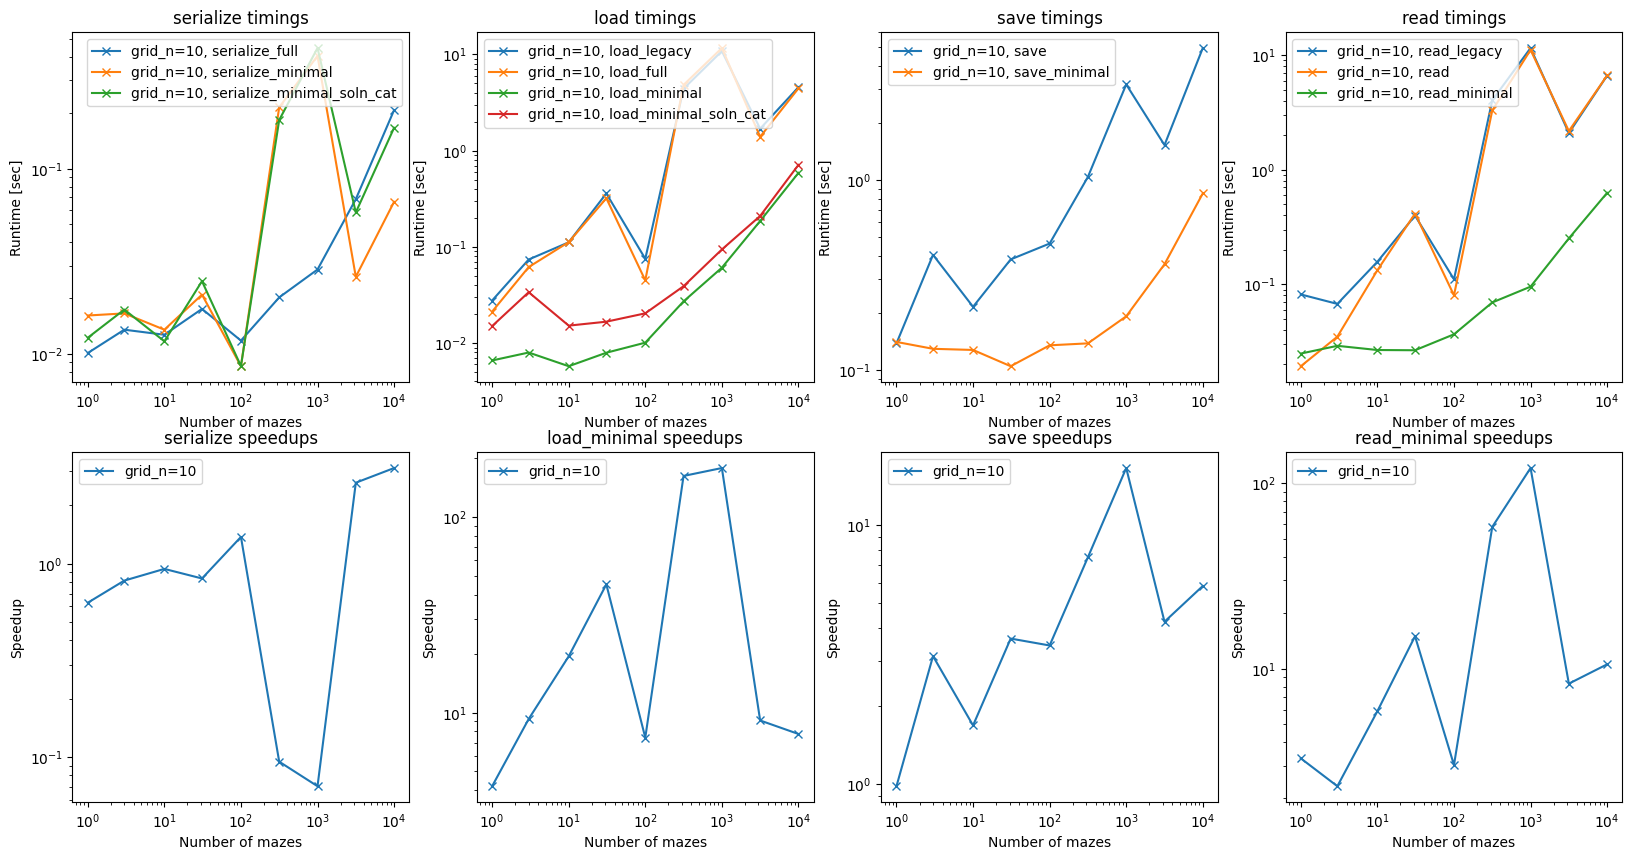

In [12]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            col_name: str = f'{prefix}' if prefix in ('serialize','save') else f'{prefix}_minimal'
            ax_speedups.plot(x_n_mazes, speeds_masked[f"{col_name}/speedup"], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{col_name} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Speedups plotted on the bottom set of axes all show the `_minimal` compared to the legacy performance. `serialize_full` and `save` are unchanged from the legacy version, so speedups are plotted relative to those vectors.

In [13]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal:profiling']]

,grid_n,n_mazes,serialize_minimal:profiling
0,10,1,<pstats.Stats object at 0x000001205377B700>
1,10,3,<pstats.Stats object at 0x000001205377BEB0>
2,10,10,<pstats.Stats object at 0x0000012053779690>
3,10,31,<pstats.Stats object at 0x00000120537780D0>
4,10,100,<pstats.Stats object at 0x000001205377B6A0>
5,10,316,<pstats.Stats object at 0x00000120533A55A0>
6,10,1000,<pstats.Stats object at 0x00000120551B5600>
7,10,3162,<pstats.Stats object at 0x000001205377A9E0>
8,10,10000,<pstats.Stats object at 0x00000120616CC250>


In [15]:
SPEEDS['load_minimal:profiling'][len(SPEEDS)-1].sort_stats('tottime').print_stats()

         112173 function calls (112093 primitive calls) in 0.826 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10000    0.440    0.000    0.542    0.000 lattice_maze.py:917(__post_init__)
    50000    0.146    0.000    0.146    0.000 {built-in method numpy.array}
    10000    0.116    0.000    0.800    0.000 lattice_maze.py:974(__init__)
        1    0.062    0.062    0.862    0.862 maze_dataset.py:322(<listcomp>)
    40000    0.051    0.000    0.051    0.000 lattice_maze.py:136(<lambda>)
       20    0.005    0.000    0.005    0.000 {built-in method nt.stat}
       56    0.001    0.000    0.002    0.000 ipkernel.py:770(_clean_thread_parent_frames)
       28    0.000    0.000    0.000    0.000 threading.py:1478(enumerate)
        1    0.000    0.000    0.007    0.007 traceback.py:338(extract)
       28    0.000    0.000    0.001    0.000 ipkernel.py:785(<setcomp>)
        1    0.000    0.000    0.001    0.001 tracebac